In [1]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
import scipy as sp
import scipy.io
import scipy.stats
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook

import cmocean
import matplotlib.patches as patches
from matplotlib import gridspec

from collections import Iterable
import matplotlib.pylab as mpl
import sys
sys.path.append(os.getcwd()+'\\..')
from utils import utils
import random as rand
from ipywidgets import *
import colorlover as cl

C:\Users\Eric\AppData\Local\Temp/ipykernel_18588/3010657804.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20)
mpl.rc('axes', labelsize=20)


bin_size = 0.025
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Load behavioral data

In [3]:
DATA_DIR = os.path.abspath('../data')

In [5]:
log_df = pd.read_hdf(os.path.join(DATA_DIR, 'log_df_02-19-19.h5'), 'table')
switch_log_df = pd.read_hdf(os.path.join(DATA_DIR, 'switching_log.h5'), 'table')

# excluded EF0088 since trained on switching task after initial CM training
switch_log_df = switch_log_df.loc[~(switch_log_df['mouse_name'] == 'EF0088'),:]

In [18]:
beh_data_files = glob.glob(os.path.join(DATA_DIR, "behavior*"))
beh_data_files

['C:\\Users\\Eric\\Documents\\09-12-2021\\finkel_et_al_2023\\data\\behavior_log.mat',
 'C:\\Users\\Eric\\Documents\\09-12-2021\\finkel_et_al_2023\\data\\behavior_log_01-31-19.mat',
 'C:\\Users\\Eric\\Documents\\09-12-2021\\finkel_et_al_2023\\data\\behavior_log_02-19-19.mat',
 'C:\\Users\\Eric\\Documents\\09-12-2021\\finkel_et_al_2023\\data\\behavior_log_02-19-19b.mat']

In [19]:
behavior_df = pd.DataFrame([])
mat = sp.io.loadmat(beh_data_files[-1])
beh_df = pd.DataFrame(mat['behavior_log'])

In [20]:
for col in range(beh_df.shape[1]): 
    beh_df.iloc[:,col] = beh_df.iloc[:,col].str[0]
    
col_names = beh_df.loc[0,:]
beh_df = beh_df.iloc[1:,:].rename(columns = col_names)

for col in [5,8]:
    beh_df.iloc[:,col] = beh_df.iloc[:,col].str[0]

beh_df.head()

,mouse_name,session_type,session_date,block_type,trial_type,trial_num,som_stim_type,vis_stim_type,response
1,EF0072,Solo.EFcross2Array,12-02-15,Visual,NoStim_Som_NoCue,1,SineAmp1Freq40Cyc40,Amp0p05Dur0p075,0
2,EF0072,Solo.EFcross2Array,12-02-15,Whisker,Stim_Som_NoCue,2,SineAmp1Freq40Cyc40,Amp0p05Dur0p075,0
3,EF0072,Solo.EFcross2Array,12-02-15,Whisker,NoStim_Som_NoCue,3,SineAmp1Freq40Cyc40,Amp0p05Dur0p075,1
4,EF0072,Solo.EFcross2Array,12-02-15,Whisker,Stim_Som_NoCue,4,SineAmp1Freq40Cyc40,Amp0p05Dur0p075,0
5,EF0072,Solo.EFcross2Array,12-02-15,Whisker,NoStim_Som_NoCue,5,SineAmp1Freq40Cyc40,Amp0p05Dur0p075,1


In [21]:
beh_df['mouse_name'].unique()

array(['EF0072', 'EF0074', 'EF0076', 'EF0077', 'EF0079', 'Ef0079',
       'EF0081', 'EF0083', 'EF0084', 'EF0085', 'EF0088', 'EF0089',
       'EF0091', 'EF0094', 'EF0098', 'EF0099', 'EF0100', 'EF0101',
       'EF00101', 'EF0102', 'EF0111', 'EF0112', 'EF0114', 'EF0131',
       'EF0132', 'EF0134', 'EF0144', 'EF0147', 'EF0149', 'EF0148',
       'EF0151', 'EF0150'], dtype=object)

#### clean up dataframe - remove unsuccessful mice, rename misnamed mice

In [22]:
beh_df = beh_df.loc[beh_df['mouse_name'] != 'EF0072', :]
beh_df = beh_df.loc[beh_df['mouse_name'] != 'EF0100', :]
beh_df.loc[beh_df['mouse_name'] == 'EF00101', 'mouse_name'] = 'EF0101'
beh_df.loc[beh_df['mouse_name'] == 'Ef0079', 'mouse_name'] = 'EF0079'

In [23]:
beh_df = beh_df[~((beh_df['mouse_name'] == 'EF0074') & beh_df['trial_type'].str.contains('NoStim'))]
log_df = log_df[~((log_df['mouse_name'] == 'EF0074') & log_df['trial_type'].str.contains('NoStim'))]

#### remove switch-task mice, reverse contingency mice, and S1 inhibition/stimulation mice from the behavioral analyses

In [24]:
beh_df = beh_df.loc[~beh_df['mouse_name'].isin(['EF0102','EF0101','EF0099','EF0091','EF0094', 
                                              'EF0098','EF0131', 'EF0132', 'EF0144', 'EF0147',
                                              'EF0148', 'EF0149','EF0150','EF0111', 'EF0112',
                                              'EF0151', # not included in any experiments
                                              'EF0134']), # not included in any experiments
                                               :]

log_df = log_df.loc[~log_df['mouse_name'].isin(['EF0102','EF0101','EF0099','EF0091','EF0094', 
                                              'EF0098','EF0131', 'EF0132', 'EF0144', 'EF0147',
                                              'EF0148', 'EF0149','EF0150','EF0111', 'EF0112',
                                              'EF0151', # not included in any experiments
                                              'EF0134']), # not included in any experiments
                                               :]

#### remove premature lick trials

In [27]:
beh_df = beh_df.loc[beh_df['response'].isin([0,1,2]).values, :]
beh_df = beh_df.sort_values(by = ['mouse_name', 'session_date', 'trial_num'])

#### remove trials following block transitions so that it is not taken into account in performance measurement - these are trials where the mouse is figuring out through trial and error that the block has switched

In [28]:
beh_df = beh_df.sort_values(by = ['mouse_name', 'session_date', 'trial_num']).reset_index()
unique_sessions = beh_df[['mouse_name', 'session_date']].drop_duplicates().reset_index(drop =True)

all_block_trans=[]
for session_row in range(unique_sessions.shape[0]):
    session = unique_sessions.loc[session_row].to_frame().T
    session_subset = pd.merge(beh_df, session, on = ['mouse_name', 'session_date'], 
                              how = 'inner').set_index('index')
    block_trans = session_subset.index[np.where((np.diff((session_subset['block_type'] == 'Visual')*1)*-1))[0]+1]
    block_trans = np.array([(x, x+1, x+2, x+3, x+4) for x in block_trans]).flatten()
    all_block_trans.append(block_trans)
    
beh_df = beh_df.loc[~beh_df['index'].isin(np.concatenate(all_block_trans)),:]
# session_subset.loc[~session_subset['trial_num'].isin(block_trans), 'correct'].mean()

#### Convert session_date column to datetime data type and remove days after full crossmodal recording finished

In [29]:
from datetime import datetime
beh_df['session_date'] = beh_df['session_date'].apply(lambda x:  datetime.strptime(x, '%m-%d-%y'))
beh_df = beh_df.sort_values(by = 'session_date').reset_index(drop = True)

## only needed for mice that were later repurposed for other experiments
last_recording_days = {'EF0114':'06-01-18'} 
for mouse, last_day in last_recording_days.items():
    beh_df = beh_df.loc[~((beh_df['mouse_name'] == mouse) & (beh_df['session_date'] > datetime.strptime(last_day, '%m-%d-%y')))]

#### define which days are the first full crossmodal training day for each mouse

In [30]:
first_CM_days = pd.DataFrame({'EF0074':'12-10-15', 'EF0076': '12-23-15', 'EF0077': '02-11-16', 'EF0079' : '02-12-16',  
                              'EF0081': '04-12-16','EF0083': '05-10-16', 'EF0084': '06-13-16', 'EF0085': '06-13-16',
                              'EF0088':'06-28-16',  'EF0089':'07-08-16','EF0091': '12-01-16', 'EF0094': '01-24-17',
                              'EF0098': '02-07-17' , 'EF0099': '02-08-17', 'EF0101' : '06-20-17', 'EF0102' : '06-20-17',
                             'EF0111':'02-20-18', 'EF0112':'02-20-18', 'EF0114':'03-12-18', 'EF0131': '06-14-18', 'EF0132':'06-21-18',
                             'EF0144':'08-01-18', 'EF0147':'10-22-18', 'EF0148':'10-22-18', 'EF0149':'10-23-18', 'EF0150':'11-02-18'}, 
                             index = ['first_train_date']).T

first_CM_days['first_train_date'] = first_CM_days['first_train_date'].apply(lambda x:  datetime.strptime(x, '%m-%d-%y'))

#### load main data table that includes ephys data. This will define which days are the test days/recorded sessions for each mouse

#### identify the first recording day for each by looking at log_df dataframes that contain only data from recording days and find the first day for each mouse

In [31]:
recording_days_sw = switch_log_df.loc[:, ['mouse_name', 'date']].drop_duplicates()
recording_days = pd.concat((log_df.loc[:, ['mouse_name', 'date']].drop_duplicates(), recording_days_sw), axis = 0)

recording_days['date_str'] = recording_days['date']
recording_days.loc[recording_days['date'].str.contains('b'), 'date'] = recording_days.loc[recording_days['date'].str.contains('b'), 'date'].apply(lambda x: x[:-1])

recording_days['date'] = recording_days['date'].apply(lambda x:  datetime.strptime(x, '%m-%d-%y'))
first_recording = {}
for mouse in recording_days['mouse_name'].unique():
    first = recording_days.loc[recording_days['mouse_name'] == mouse, 'date'].min()
    first_recording[mouse] = first
first_recording = pd.DataFrame(first_recording, index = ['first_rec_date']).T


#### define trials which are fullstim vs short stim

In [32]:
beh_df['full_stim'] = 0
beh_df.loc[~beh_df['trial_type'].str.contains('1Cyc'), 'full_stim'] = 1

#### define trials as hit/miss/cr/fa and whether they were correct or not

In [33]:
def classify_trials(df):
    rev_cont_mice = df['mouse_name'].isin(['EF0091', 'EF0099', 'EF0101', 'EF0102'])

    touch_match_trials = ((df['block_type']=='Whisker') & df['trial_type'].str.contains('Som'))
    visual_match_trials = ((df['block_type']=='Visual') & df['trial_type'].str.contains('Vis'))
    non_match_trials = (((df['block_type']=='Visual') & (df['trial_type'].str.contains('Som'))) |
                    ((df['block_type']=='Whisker') & (df['trial_type'].str.contains('Vis'))))


    hits = ((touch_match_trials & ~rev_cont_mice & (df['response'] ==1)) | (visual_match_trials & ~rev_cont_mice & (df['response'] ==2)) |
            (touch_match_trials & rev_cont_mice & (df['response'] ==2)) | (visual_match_trials & rev_cont_mice & (df['response'] ==1)))
    miss = (touch_match_trials & (df['response'] ==0)) | (visual_match_trials & (df['response'] ==0))
    false_alarms = ((non_match_trials & (df['response'] != 0)) | 
                    ((touch_match_trials & ~rev_cont_mice & (df['response'] ==2)) |
                     (visual_match_trials & ~rev_cont_mice & (df['response'] ==1)) |
                     (touch_match_trials & rev_cont_mice & (df['response'] ==1)) | 
                     (visual_match_trials & rev_cont_mice & (df['response'] ==2))))
    correct_rej = (non_match_trials & (df['response'] == 0))

    df['Hits'] = hits
    df['FAs'] = false_alarms
    df['Misses'] = miss
    df['CRs'] = correct_rej
    df['correct'] = hits|correct_rej
    return df

beh_df = classify_trials(beh_df)
log_df = classify_trials(log_df)

#### identify days that contain short trials

In [34]:
days_with_short_stim = beh_df.groupby(['mouse_name', 'session_date']).apply(lambda x: x['full_stim'].mean()<0.9).reset_index().rename(columns = {0:'has_1cyc_stim'})
beh_df = beh_df.merge(days_with_short_stim)

In [35]:
short_stim_performance = pd.pivot_table(beh_df[(beh_df['full_stim'] == 0) & (beh_df['has_1cyc_stim'])], index = ['mouse_name', 'session_date'],
                                       values = 'correct', aggfunc = np.mean)
full_stim_performance = pd.pivot_table(beh_df[beh_df['full_stim'] == 1], index = ['mouse_name', 'session_date'],
                                       values = 'correct', aggfunc = np.mean)

In [36]:
block_performance_short = pd.pivot_table(beh_df[(beh_df['full_stim'] == 0) &(beh_df['has_1cyc_stim'])], index = ['mouse_name', 'session_date'],
                                         columns = ['block_type'], values = 'correct', aggfunc = np.mean)
block_performance_full = pd.pivot_table(beh_df[beh_df['full_stim'] == 1], index = ['mouse_name', 'session_date'],
                                        columns = ['block_type'], values = 'correct', aggfunc = np.mean)
block_performance_short.head()

block_type                 Visual   Whisker
mouse_name session_date                    
EF0074     2016-02-04    0.818182  0.476190
           2016-02-05    0.812500  0.617021
           2016-02-06    0.781818  0.576923
           2016-02-08    0.771429  0.418605
           2016-02-24    0.820513  0.520000

#### calculate the proportion of trials that are hits, misses, FA, and CR for each mouse during the recording sessions

In [37]:
rec_days_trials = pd.merge(beh_df, recording_days, left_on = ['mouse_name', 'session_date'],
                           right_on = ['mouse_name', 'date'], how = 'inner')

avg_tb_proportions_ind_mouse = []
std_tb_proportions_ind_mouse = []

avg_vb_proportions_ind_mouse = []
std_vb_proportions_ind_mouse = []
for mouse in rec_days_trials['mouse_name'].drop_duplicates():
    mouse_rec_days = rec_days_trials[rec_days_trials['mouse_name'] == mouse]
    t_block = mouse_rec_days['block_type'] == 'Whisker'
    v_block = mouse_rec_days['block_type'] == 'Visual'
    v_trial = mouse_rec_days['trial_type'].str.contains('Vis')
    t_trial = mouse_rec_days['trial_type'].str.contains('Som')
    lick = mouse_rec_days['response'] != 0
    correct = mouse_rec_days['correct'] ==1

    tb_hits = t_block & lick & correct
    tb_misses = t_block & ~lick & ~correct
    tb_FA = t_block & lick & ~correct
    tb_CR = t_block & ~lick & correct

    vb_hits = v_block & lick & correct
    vb_misses = v_block & ~lick & ~correct
    vb_FA = v_block & lick & ~correct
    vb_CR = v_block & ~lick & correct

    
    tb_trial_types = [tb_hits, tb_misses, tb_FA, tb_CR]
    vb_trial_types = [vb_hits, vb_misses, vb_FA, vb_CR]
    avg_tb_proportions_ind_mouse.append([sum(tt*1)/sum(t_block*1) for tt in tb_trial_types])
    avg_vb_proportions_ind_mouse.append([sum(tt*1)/sum(v_block*1) for tt in vb_trial_types])
    std_tb_proportions_ind_mouse.append([sum(tt*1)/sum(t_block*1) for tt in tb_trial_types])
    std_vb_proportions_ind_mouse.append([sum(tt*1)/sum(t_block*1) for tt in vb_trial_types])
#     print(avg_tb_proportions)

avg_tb_proportions = np.array(avg_tb_proportions_ind_mouse).mean(axis = 0)
avg_vb_proportions = np.array(avg_vb_proportions_ind_mouse).mean(axis = 0)
std_tb_proportions = np.array(std_tb_proportions_ind_mouse).std(axis = 0)
std_vb_proportions = np.array(std_vb_proportions_ind_mouse).std(axis = 0)
trial_type_labels = ['Hits', 'Misses', 'False alarms', 'Correct rejections']

std_tb_proportions

array([0.03532512, 0.03638019, 0.02462589, 0.02365025])

In [38]:
mean_corr_tb = np.mean([m[0]+m[3] for m in avg_tb_proportions_ind_mouse])
sem_corr_tb = np.std([m[0]+m[3] for m in avg_tb_proportions_ind_mouse])/np.sqrt(len(avg_tb_proportions_ind_mouse))

mean_corr_vb = np.mean([m[0]+m[3] for m in avg_vb_proportions_ind_mouse])
sem_corr_vb = np.std([m[0]+m[3] for m in avg_vb_proportions_ind_mouse])/np.sqrt(len(avg_vb_proportions_ind_mouse))

sem_corr_tb, sem_corr_vb

(0.005473195419951816, 0.010038175228674796)

In [39]:
mean_corr_tb, mean_corr_vb

(0.7279763374159874, 0.7514970329041089)

## paired t-test of percent correct

In [40]:
tactile_pc = np.array([ms_tt[0] + ms_tt[-1] for ms_tt in avg_tb_proportions_ind_mouse])
visual_pc = np.array([ms_tt[0] + ms_tt[-1] for ms_tt in avg_vb_proportions_ind_mouse])
scipy.stats.ttest_rel(tactile_pc, visual_pc)

Ttest_relResult(statistic=-1.6898752737146903, pvalue=0.12193398484423441)

#### calculate performance of mice on each crosmodal training session first for full and then for short stimuli

In [41]:
beh_df['mouse_name'].unique()

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0083',
       'EF0084', 'EF0085', 'EF0088', 'EF0089', 'EF0114'], dtype=object)

In [42]:
cm_training_perf_full = {}
block_training_perf_full = {}
for mouse in beh_df['mouse_name'].unique():
    if first_recording.index.isin([mouse]).any():
        drop_inds = ~((full_stim_performance.loc[mouse].index >= first_CM_days.loc[mouse, 'first_train_date']) & 
                      (full_stim_performance.loc[mouse].index <= first_recording.loc[mouse, 'first_rec_date']))
        cm_training_perf_full[mouse] = full_stim_performance.loc[mouse].drop(np.array(full_stim_performance.loc[mouse].index)[drop_inds])
        block_training_perf_full[mouse] = block_performance_full.loc[mouse].drop(np.array(block_performance_full.loc[mouse].index)[drop_inds])
# del cm_training_perf_full['EF0091']
# del block_training_perf_full['EF0091'] ## excluded since initially attempted to train on delay task before switching to CM

In [43]:
cm_training_perf_short = {}
block_training_perf_short = {}

for mouse in beh_df['mouse_name'].unique():
    if short_stim_performance.index.levels[0].isin([mouse]).any():
        # drop days before full recording days
        drop_inds = ~((short_stim_performance.loc[mouse].index >= first_CM_days.loc[mouse, 'first_train_date']) & 
                      (short_stim_performance.loc[mouse].index <= first_recording.loc[mouse, 'first_rec_date']))
        cm_training_perf_short[mouse] = short_stim_performance.loc[mouse].drop(np.array(short_stim_performance.loc[mouse].index)[drop_inds])
        block_training_perf_short[mouse] = block_performance_short.loc[mouse].drop(np.array(block_performance_short.loc[mouse].index)[drop_inds])


#### add days in which no units were recorded and there for dont show up in log_df.

In [44]:
### days in which no units were recorded dont show up in log_df and therefore must be manually entered
additional_rec_days = {}
additional_rec_days['EF0079'] = ['02-24-16', '02-26-16', '03-23-16', '03-28-16']
additional_rec_days['EF0074'] = []
additional_rec_days['EF0076'] = []
additional_rec_days['EF0081'] = []
additional_rec_days['EF0077'] = ['05-12-16']
additional_rec_days['EF0084'] = ['07-26-16']
additional_rec_days['EF0083'] = ['05-25-16','05-27-16','05-28-16','06-01-16','06-02-16','06-05-16','06-07-16']
additional_rec_days['EF0085'] = ['08-02-16','08-16-16','08-18-16','08-19-16']
additional_rec_days['EF0089'] = ['09-14-16', '09-06-16']
additional_rec_days['EF0088'] = []
additional_rec_days['EF0099'] = []
additional_rec_days['EF0101'] = []
additional_rec_days['EF0102'] = ['08-17-17', '08-21-17']

In [45]:
for mouse in list(cm_training_perf_full.keys()):
    if mouse in additional_rec_days:
        add_days = pd.concat((pd.DataFrame([mouse]*len(additional_rec_days[mouse]), columns = ['mouse_name']), 
                                           pd.DataFrame(additional_rec_days[mouse], columns = ['date'])), axis = 1)
        add_days['date'] = add_days['date'].apply(lambda x:  datetime.strptime(x, '%m-%d-%y'))
        recording_days = recording_days.append(add_days)
recording_days = recording_days.sort_values(by=['mouse_name', 'date'])

#### EF0101 EF0102 underwent headcap surgery then trained to criterion then inplanted. After implantation the mouse needed a few days to recover performance leading to significantly longer time to criterion. Will remove these recovery days for the the next analysis:

In [46]:
cm_training_perf_full.keys()

dict_keys(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0083', 'EF0084', 'EF0085', 'EF0088', 'EF0089', 'EF0114'])

In [47]:
# cm_training_perf_full['EF0101'] = cm_training_perf_full['EF0101'][cm_training_perf_full['EF0101'].index <= '2017-07-21']
# cm_training_perf_full['EF0102'] = cm_training_perf_full['EF0102'][cm_training_perf_full['EF0102'].index < '2017-07-27']
# block_training_perf_full['EF0101']  = block_training_perf_full[mouse][block_training_perf_full[mouse].index <= '2017-07-21']
# block_training_perf_full['EF0102']  = block_training_perf_full[mouse][block_training_perf_full[mouse].index < '2017-07-27']

In [48]:
recording_days = recording_days.reset_index(drop=True)

In [49]:
np.array([str(mouse) + ' ' + str(len(cm_training_perf_full[mouse])) for mouse in list(cm_training_perf_full.keys())])

array(['EF0074 13', 'EF0076 25', 'EF0077 37', 'EF0079 13', 'EF0081 11',
       'EF0083 19', 'EF0084 9', 'EF0085 38', 'EF0088 37', 'EF0089 31',
       'EF0114 18'], dtype='<U9')

In [50]:
block_performance_full.columns.rename('index', inplace = True)
block_performance_full = block_performance_full.reset_index()

block_performance_short.columns.rename('index', inplace = True)
block_performance_short = block_performance_short.reset_index()

full_stim_performance = full_stim_performance.reset_index()
short_stim_performance = short_stim_performance.reset_index()

In [51]:
performance = pd.merge(block_performance_full, full_stim_performance, on = ['mouse_name', 'session_date'])
performance_short = pd.merge(block_performance_short, short_stim_performance, on = ['mouse_name', 'session_date'])

### Remove all recording days where performance dropped below 65% will not be present in all further analyses
#### Although mice reach criterion there would be the occasional day after recording phase began where mice would perform badly. This is possibly due to excessive water restriction, insufficient water restriction, or other difficult to control factors. Since we only care to see how the neurons are responding to the task variables in highly performing mice we chose to exclude these 'off days' from further analysis

In [53]:
recording_day_inds = pd.merge(performance.reset_index(),recording_days, left_on = ['mouse_name', 'session_date'], 
         right_on = ['mouse_name', 'date'])['index'].values

performance['rec_day'] = 0
performance.loc[recording_day_inds, 'rec_day'] = 1
performance.loc[(performance['correct'] < 0.65), 'rec_day'] = 0

rec_performance = performance[performance['rec_day'] == 1]
recording_day_inds_short = pd.merge(performance_short.reset_index(), rec_performance, 
                                    on = ['mouse_name', 'session_date'])['index'].values
performance_short['rec_day'] = 0
performance_short.loc[recording_day_inds_short, 'rec_day'] = 1

In [54]:
block_performance_short['mouse_name'].unique(), block_performance_full['mouse_name'].unique()

(array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0083',
        'EF0084', 'EF0085', 'EF0088', 'EF0089'], dtype=object),
 array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0083',
        'EF0084', 'EF0085', 'EF0088', 'EF0089', 'EF0114'], dtype=object))

# Figure1(C) and (D): Learning curves and test session performance for three example mice, other beh quantification

In [55]:
avg_tb_proportions[0] + avg_tb_proportions[3], avg_vb_proportions[0] + avg_vb_proportions[3]

(0.7279763374159873, 0.7514970329041087)

<AxesSubplot:ylabel='Fraction trials'>

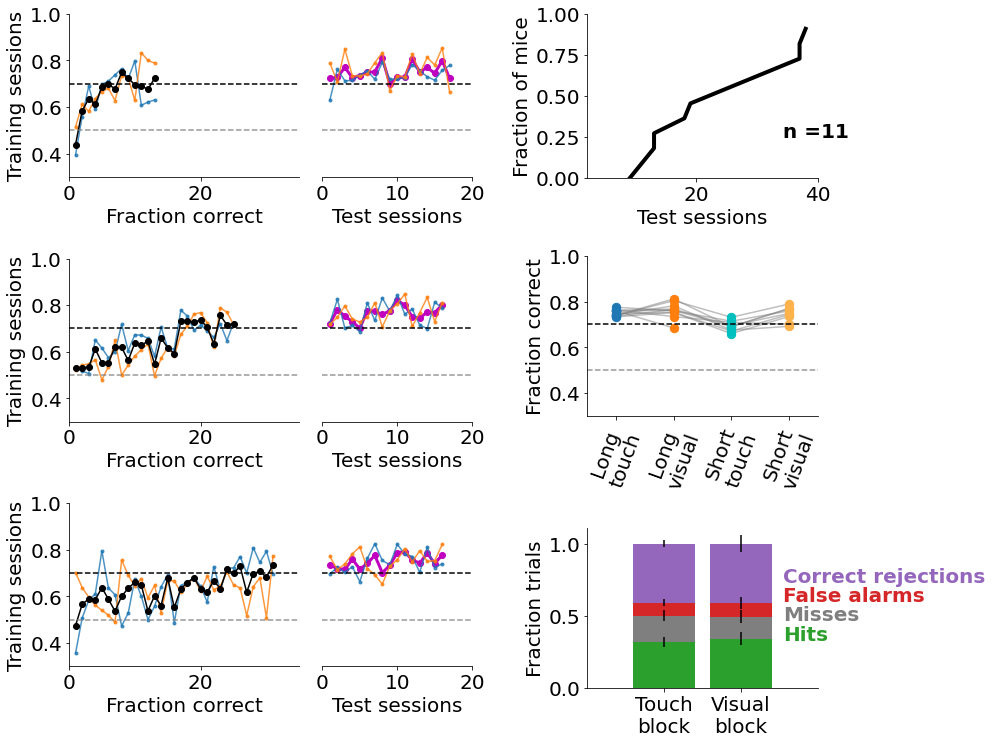

In [58]:
mpl.close('all')

##to plot example mice:
mouse_list = ['EF0074', 'EF0076', 'EF0089']
time_to_crit = np.array([len(cm_training_perf_full[mouse]) for mouse in mouse_list])
ordered_mice = np.array(mouse_list)[np.argsort(time_to_crit)]

fig1a = mpl.figure(figsize = (16,len(mouse_list)*4))
gs1 = gridspec.GridSpec(len(mouse_list),1); gs1.update(left = 0.2, right = 0.4, hspace = 0.5)
gs2 = gridspec.GridSpec(len(mouse_list),1); gs2.update(left = 0.42, right = 0.55, hspace = 0.5)
gs3 = gridspec.GridSpec(1,1); gs3.update(bottom = 0.69, left = 0.65, right = 0.85, hspace = 0.5)
gs4 = gridspec.GridSpec(2,1); gs4.update(bottom = 0.1, top = 0.6, left = 0.65, right = 0.85, hspace = 0.7)

######## training and test line plots ###############################
for i, mouse in enumerate(ordered_mice):
    mouse_rec_perf = performance[(performance['rec_day'] == 1) & (performance['mouse_name'] == mouse)] 
    mouse_rec_perf_short = performance_short[(performance_short['rec_day'] == 1) & (performance_short['mouse_name'] == mouse)]

    ax1 = mpl.subplot(gs1[i, 0])
    xmax_tr = len(cm_training_perf_full[mouse])+1
    ax1.plot(range(1,xmax_tr), block_training_perf_full[mouse]['Whisker'], '-oC0', markersize = 3, alpha = 0.8)
    ax1.plot(range(1,xmax_tr), block_training_perf_full[mouse]['Visual'], '-oC1', markersize = 3, alpha = 0.8)
    ax1.plot(range(1,xmax_tr), cm_training_perf_full[mouse], '-ok')

    ax2 = mpl.subplot(gs2[i, 0])
    xmax_rec = mouse_rec_perf.shape[0]
    ax2.plot(range(1, xmax_rec+1,1), mouse_rec_perf['correct'], '-om', linewidth = 3)
    ax2.plot(range(1, xmax_rec+1,1), mouse_rec_perf['Whisker'], '-oC0', markersize = 3, alpha = 0.8)
    ax2.plot(range(1, xmax_rec+1,1), mouse_rec_perf['Visual'], '-oC1', markersize = 3, alpha = 0.8)

    for ax in [ax1, ax2]:
        ax.plot([0, 45], [0.7, 0.7], '--k')
        ax.plot([0, 45], [0.5, 0.5], '--C7', alpha = 0.8)
        utils.prettify_ax(ax, 'Fraction correct','Training sessions', y_lim = [0.3,1], x_lim = [0,35])
    ax2.set_xlim(0,20)
    ax2.spines['left'].set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_xlabel('Test sessions')

######## training time cummulative histogram ###############################
ax3 = mpl.subplot(gs3[0, 0])
time_to_crit_all = np.array([len(cm_training_perf_full[mouse]) for mouse in list(cm_training_perf_full.keys())])
X2 = np.sort(time_to_crit_all)
F2 = np.array(range(len(time_to_crit_all)))/len(time_to_crit_all)
ax3.plot(X2, F2, 'k', linewidth = 4)
ax3.text(.85, .25, 'n =' + str(len(time_to_crit_all)), size=20, weight = 'bold', transform=ax3.transAxes, color='k')

######## stimulus type fraction correct plot ###############################
ax4 = mpl.subplot(gs4[0, 0])
full_mouse_list = list(cm_training_perf_full.keys())
for mouse in full_mouse_list:
    mouse_rec_perf = performance[(performance['rec_day'] == 1) & (performance['mouse_name'] == mouse)] 
    mouse_rec_perf_short = performance_short[(performance_short['rec_day'] == 1) & (performance_short['mouse_name'] == mouse)]
    xvals = [0,1]
    rec_block_perf = mouse_rec_perf[['Whisker', 'Visual']]

    if mouse in block_performance_short['mouse_name'].values:
        mouse_rec_perf_short.columns = ['mouse_name', 'session_date','short_vis', 'short_whisker', 'correct', 'rec_days']
        rec_block_perf = pd.concat((rec_block_perf,  mouse_rec_perf_short[['short_vis', 'short_whisker']]), axis = 1)
        rec_block_perf = rec_block_perf[['Whisker', 'Visual', 'short_whisker', 'short_vis']]
        xvals = [0,1,2,3]
        m_rec_block_perf = rec_block_perf.mean(axis = 0)
        ax4.scatter([3], m_rec_block_perf['short_vis'], color = '#feb24c', s = 70)
        ax4.scatter([2], m_rec_block_perf['short_whisker'], color = 'c', s = 70)
        
    m_rec_block_perf = rec_block_perf.mean(axis = 0)
    ax4.plot(xvals, m_rec_block_perf, 'C7', zorder = 0, alpha = 0.5)
    ax4.scatter([1], m_rec_block_perf['Visual'], color = 'C1', s = 70)
    ax4.scatter([0], m_rec_block_perf['Whisker'], color = 'C0', s = 70)
ax4.plot([-0.5, 3.5], [0.7, 0.7], '--k')
ax4.plot([-0.5, 3.5], [0.5, 0.5], '--C7', alpha = 0.8)
mpl.xticks([0,1,2,3], ['Long\ntouch', 'Long\nvisual', 'Short\ntouch', 'Short\nvisual'], rotation=70)

######## stacked bar plot ###############################################
ax5 = mpl.subplot(gs4[1, 0])
colors = ['C2', 'C7', 'C3', 'C4']
bottom = 0
for tt in range(len(avg_tb_proportions)):
    ax5.bar(0, avg_tb_proportions[tt], bottom = bottom, color = colors[tt], yerr = std_tb_proportions[tt])
    ax5.text(.85, .3+.12*tt, trial_type_labels[tt], size=20, weight = 'bold', transform=ax5.transAxes, color = colors[tt])
    bottom = bottom + avg_tb_proportions[tt]
    
bottom = 0
for tt in range(len(avg_vb_proportions)):
    ax5.bar(1, avg_vb_proportions[tt], bottom = bottom, color = colors[tt], yerr = std_vb_proportions[tt])
    bottom = bottom + avg_vb_proportions[tt]
mpl.xticks([0,1], ['Touch\nblock', 'Visual\nblock'])

############## tidy up plot #############################################
utils.prettify_ax(ax3, 'Test sessions','Fraction of mice', y_lim = [0,1], x_lim = [2,40])
utils.prettify_ax(ax4, '','Fraction correct', y_lim = [0.3,1], x_lim = [-0.5,3.5])
utils.prettify_ax(ax5, '','Fraction trials', x_lim = [-1,2])

# fig1a.savefig('fig_1a.pdf', format = 'pdf', dpi = 900)

In [59]:
avg_tb_proportions

array([0.31861287, 0.18236638, 0.08965729, 0.40936347])

## Reaction times boxplot

In [60]:
recording_day_RTs = log_df.drop(['cluster_name','spike_times(stim_aligned)', 'identified'], axis = 1)
recording_day_RTs.drop_duplicates(['mouse_name', 'date', 'trial_num'], inplace = True)
recording_day_RTs.reset_index(drop = True, inplace = True) 

In [61]:
recording_day_RTs['trial_outcome'] = np.nan

long_stim = ~recording_day_RTs['trial_type'].str.contains('1Cyc')
touch_stim = recording_day_RTs['trial_type'].str.contains('Som')
touch_block = recording_day_RTs['block_type'] == 'Whisker'
correct = recording_day_RTs['correct']

recording_day_RTs.loc[(long_stim & touch_stim & touch_block & correct), 'trial_outcome'] = 'touch_hit_long'
recording_day_RTs.loc[(~long_stim & touch_stim & touch_block & correct), 'trial_outcome'] = 'touch_hit_short'
recording_day_RTs.loc[(long_stim & ~touch_stim & ~touch_block & correct), 'trial_outcome'] = 'visual_hit_long'
recording_day_RTs.loc[(~long_stim & ~touch_stim & ~touch_block & correct), 'trial_outcome'] = 'visual_hit_short'

trial_type_RTs = pd.pivot_table(recording_day_RTs, index = ['mouse_name', 'date', 'trial_outcome'],
               values = 'first_lick', aggfunc = np.median).reset_index()

Text(0.5, 0, 'Reaction time (s)')

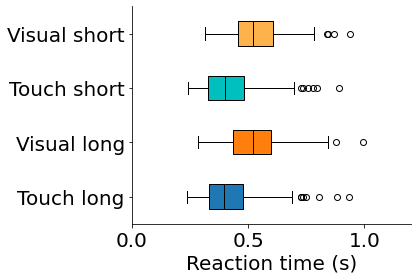

In [62]:

mpl.close('all')
fig1a_1 = mpl.figure(figsize = (5,4))
ax = fig1a_1 .add_subplot(111)

colors = [ 'C0','C1', 'c', '#feb24c' ]
titles = ['Touch long', 'Visual long', 'Touch short', 'Visual short']

t_long = trial_type_RTs.loc[trial_type_RTs['trial_outcome'] == 'touch_hit_long', 'first_lick']
t_short = trial_type_RTs.loc[trial_type_RTs['trial_outcome'] == 'touch_hit_short', 'first_lick']
v_long = trial_type_RTs.loc[trial_type_RTs['trial_outcome'] == 'visual_hit_long', 'first_lick']
v_short = trial_type_RTs.loc[trial_type_RTs['trial_outcome'] == 'visual_hit_short', 'first_lick']
bplot = ax.boxplot([t_long, v_long, t_short, v_short],labels = titles, vert = False, patch_artist=True)

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

mpl.setp(bplot['medians'], color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,1.2])
ax.set_xlabel('Reaction time (s)')   


In [63]:
t_long.median(), t_short.median(), v_long.median(), v_short.median()

(0.3974000000000011,
 0.4009833333333337,
 0.5190833333333325,
 0.5227749999999998)

In [66]:
IQRs = []
for cond in [t_long, t_short, v_long, v_short]:
    q3,q1 = cond.quantile([0.75, 0.25]).values
    IQRs.append(q3-q1)
    
IQRs

[0.1454250000000002,
 0.15455416666666644,
 0.16336666666666633,
 0.15409583333333327]

In [67]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
index = np.concatenate([['t_long']*len(t_long),['t_short']*len(t_short),['v_long']*len(v_long),['v_short']*len(v_short)])
rt_data = (np.concatenate([t_long,t_short,v_long, v_short]))

print(pairwise_tukeyhsd(rt_data, index))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 t_long t_short   0.0014 0.9998 -0.0386 0.0413  False
 t_long  v_long    0.106    0.0  0.0685 0.1435   True
 t_long v_short   0.1122    0.0  0.0722 0.1522   True
t_short  v_long   0.1046    0.0  0.0647 0.1446   True
t_short v_short   0.1108    0.0  0.0686 0.1531   True
 v_long v_short   0.0062 0.9782 -0.0337 0.0461  False
-----------------------------------------------------


In [68]:
fig1a_1.savefig('reaction_time_dist.pdf', format='pdf', dpi=900)

In [69]:
all_t_RT = pd.concat([t_long, t_short])
all_v_RT = pd.concat([v_long, v_short])

t_IQR_med = np.percentile(all_t_RT, [25,50,75])
v_IQR_med = np.percentile(all_v_RT, [25,50,75])


print(f'touch med: {t_IQR_med[1]}\ntouch 1.5 x IQR: {1.5*(t_IQR_med[2]-t_IQR_med[0])}')
print(f'visual med: {v_IQR_med[1]}\ntouch 1.5 x IQR: {1.5*(v_IQR_med[2]-v_IQR_med[0])}')

touch med: 0.3974000000000011
touch 1.5 x IQR: 0.2240000000000018
visual med: 0.5210833333333335
touch 1.5 x IQR: 0.2525374999999989


# Fig1(B) three example behavioral sessions

In [70]:
def get_trial_results(mouse, date_ind):
    last_rec_day = recording_days[recording_days['mouse_name'] == mouse].iloc[-1]['date']
    ex_mouse = beh_df[beh_df['mouse_name'] == mouse].sort_values(by = ['session_date', 'trial_num'])
    ex_mouse = ex_mouse[(ex_mouse['session_date'] >= first_CM_days.loc[mouse][0]) & (ex_mouse['session_date'] <= last_rec_day)]
    date = ex_mouse['session_date'].unique()[date_ind]
    example_day = ex_mouse.loc[(ex_mouse['mouse_name'] == mouse) & (ex_mouse['session_date'] == date)]
    
    t_block = example_day['block_type'] == 'Whisker'
    v_block = example_day['block_type'] == 'Visual'
    t_trial = example_day['trial_type'].str.contains('Som')
    v_trial = example_day['trial_type'].str.contains('Vis')
    lick = example_day['response'] != 0

    touch_lick = (t_trial & lick)*1
    visual_lick =  (v_trial & lick)*1
    touchNL = (t_trial & ~lick)*1
    visualNL = (v_trial & ~lick)*1
    
    print(example_day['correct'].mean())
    print(example_day[['mouse_name', 'session_date']].iloc[0])
    
    return touch_lick, visual_lick, touchNL, visualNL, t_block

In [74]:
mpl.close('all')
def plot_session_perf(mouse, date_ind):
    touch_lick, visual_lick, touchNL, visualNL, t_block= get_trial_results(mouse, date_ind)

    fig = mpl.figure(figsize = (9.5,3.5))
    fig.subplots_adjust(bottom = 0.2)
    ax = fig.add_subplot(111)

    w = 15
    tL_height = np.convolve(touch_lick, [1/w]*w, 'valid')
    vL_height = np.convolve(visual_lick, [1/w]*w, 'valid')
    tNL_height = np.convolve(touchNL, [1/w]*w, 'valid')
    vNL_height = np.convolve(visualNL, [1/w]*w, 'valid')
    lick_height = vL_height +tL_height

    g0 = -.5*(vL_height + tL_height)
    g0 = [0] * len(lick_height) 
    fs = [tNL_height, tL_height, vL_height, vNL_height]
    xvals = np.arange(0,len(lick_height))
    g_n = g0
    labels =  ['Touch-no lick', 'Touch-lick', 'Visual-lick', 'Visual-no lick' ]
    colors = [[0.7]*3, 'C0',  'C1', [0.5]*3]
    
    for i,g_i in enumerate(fs):
        color = colors[i]
        ax.fill_between(xvals, g_n, g_n+g_i, color = colors[i], alpha = 0.5)
        if i == 1:
            ax.plot(xvals, g_n, color = colors[i])

        elif i == 3:
            ax.plot(xvals, g_n, color = colors[i-1])

        g_n = g_n + g_i
        ax.text(.85, .1+.12*i, labels[i], size=20, weight = 'bold', transform=ax.transAxes, color = colors[i])

    xoffset = int(np.floor((t_block.size - len(xvals))/2))
    val_t_block = t_block.values[xoffset: xoffset+len(xvals)]
    block_changes = np.concatenate([[0],  np.where(np.diff(val_t_block*1))[0] ,[len(val_t_block)]])

    block = 0
    if t_block.iloc[3] == 1:
        block_colors = ['C0', 'C1']
    else:
        block_colors = ['C1', 'C0']
    for i in range(len(block_changes)-1):
        ax.add_patch(patches.Rectangle((block_changes[i],1.1),  block_changes[i+1]-block_changes[i],
                                       .1, facecolor = block_colors[i%2], alpha = 0.5))
        block = block + 1

    ax.text(.05, .9, 'Touch block', size=20, weight = 'bold', transform=ax.transAxes, color = 'C0', alpha = 0.5)
    ax.text(.3, .9, 'Visual block', size=20, weight = 'bold', transform=ax.transAxes, color = 'C1', alpha = 0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0,1.4)
    ax.spines['bottom'].set_position(('axes', -0.1))
    ax.set_yticks([0,0.5,1])
    ax.spines['bottom'].set_bounds(150, 200)
    ax.spines['left'].set_bounds(0, 1)
    ax.set_xlim(-5,300)
    ax.set_ylabel('Fraction of trials')
    ax.tick_params(axis=u'both', which=u'both',length=0)
    mpl.xticks([175],['50 trials'])
    ax.yaxis.set_label_coords(-.05, .35)


0.5526315789473685
mouse_name                   EF0076
session_date    2016-01-03 00:00:00
Name: 7977, dtype: object


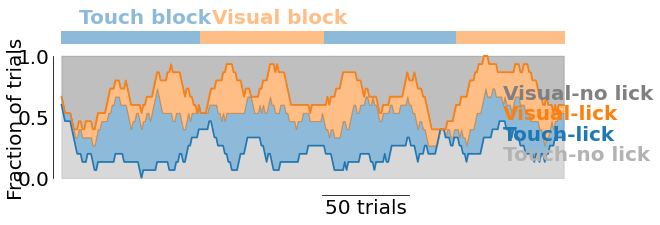

In [75]:
plot_session_perf('EF0076', 4)

# mpl.gcf().savefig('early_training.pdf', format = 'pdf', dpi = 900)

0.62890625
mouse_name                   EF0076
session_date    2016-01-29 00:00:00
Name: 17263, dtype: object


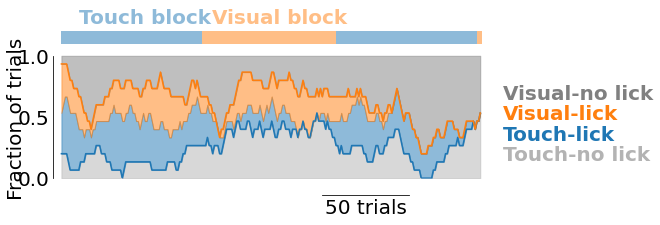

In [77]:
plot_session_perf('EF0076', 13)
# mpl.gcf().savefig('mid_training.pdf', format = 'pdf', dpi = 900)

0.7598566308243727
mouse_name                   EF0076
session_date    2016-02-15 00:00:00
Name: 28438, dtype: object


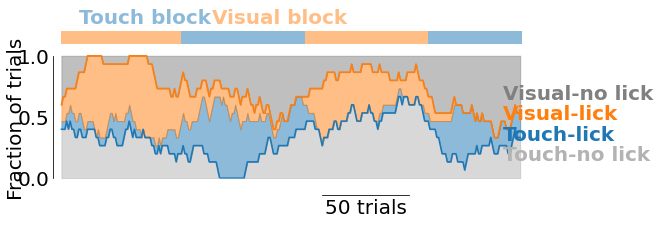

In [78]:
plot_session_perf('EF0076', 27)
# mpl.gcf().savefig('full_training.pdf', format = 'pdf', dpi = 900)